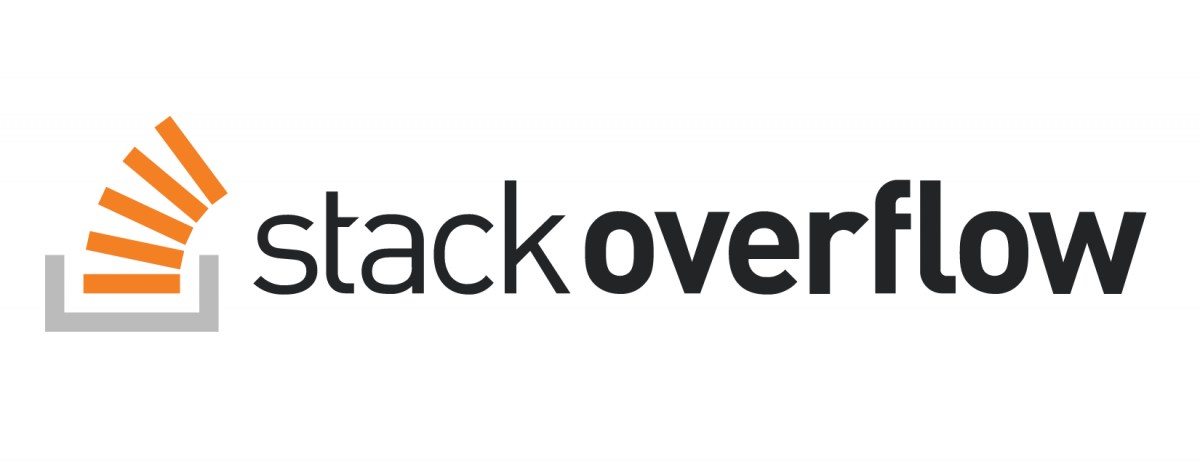

pic credit - google images

**This Dataset contain 60,000 Stack Overflow questions from 2016-2020 and classified them into three categories**

* HQ: High-quality posts with 30+ score and without a single edit.

* LQ_EDIT: Low-quality posts with a negative score and with multiple community edits. However, they still remain open after the edits.

* LQ_CLOSE: Low-quality posts that were closed by the community without a single edit.

# What we will cover in this Notebook

> Cleaning and formatting dataset

> Visualizing dataset and find some usefull insight out of it

> Carving text for Neural Network Classification

> Performing Keras LSTM for 
  * Multi-Class text Classification
  * Multi-Label text Classification

**First Import some basice Libraries**

In [ ]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bsp
import datetime as dt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS 

import warnings
warnings.filterwarnings('ignore')

import re


%matplotlib inline

**Reading Dataset and Previewing First 10 Values**

In [ ]:
data = pd.read_csv("../input/60k-stack-overflow-questions-with-quality-rate/data.csv")
data.head(10)

**Checking some basic information about dataset**

In [ ]:
data.info()

In [ ]:
data.shape

In [ ]:
data.describe(include='object').transpose()

# Cleaning and Preprocessing Dataset

We can see that Body and Tags Columns are in HTML Tag, so we will basicly extract only text from HTML Tag

In [ ]:
data['Body'][0]

In [ ]:
data['Tags'][10]

In [ ]:
data['CleanBody'] = data['Body'].apply(lambda x:bsp(x,'html.parser').text.replace('\\','').replace('\n','').replace('\t','').replace('\r',''))
data['Tags'] = data['Tags'].apply(lambda x:x.replace('<','').replace('>',' '))

**Converting CreationDate Column Value datatype from object to pandas Datetime**

In [ ]:
data['CreationDate'] = pd.to_datetime(data['CreationDate'],errors='coerce')

data['CreationMonth'] = data['CreationDate'].dt.month
data['CreationDay'] = data['CreationDate'].dt.day
data['CreationYear'] = data['CreationDate'].dt.year
data['CreationQuater'] = data['CreationDate'].dt.quarter
data['CreationDate'] = data['CreationDate'].dt.date

# Visualization

Checking Frequency of Question's Quality year by year

In [ ]:
fig = px.histogram(data,x='CreationDate',title='Question\'s Quality year by year',color='Y')

fig.update_layout(height = 700)
fig.update_xaxes(categoryorder='category descending',title='Date').update_yaxes(title='Number of Questions')

fig.show()

Below Graph show Amount of Questions asked year by year

In [ ]:
fig = px.histogram(data,x='CreationDate',title='Number of Question year by year')

fig.update_layout(height = 700)
fig.update_xaxes(categoryorder='category descending',title='Date').update_yaxes(title='Number of Questions')

fig.show()

Below Bar Chart show Frequency of Question's Quality year by year 

In [ ]:
fig = px.histogram(data,x='CreationDate',title='Question\'s Quality year by year',color='Y',nbins=6,barmode = 'group')

fig.update_layout(height = 700)
fig.update_xaxes(categoryorder='category descending',title='Date').update_yaxes(title='Number of Questions')

fig.show()

In [ ]:
allTags = data['Tags'].apply(lambda x: x.lower())
allTags = allTags.values
allTags = list(allTags)
allTags = ''.join(allTags)
count = Counter(allTags.split())


count = pd.DataFrame(list(dict(count).items()),columns = ['Technology','Count'])
count.astype({'Count':'int64'})

count.sort_values('Count',axis =0,ascending = False,inplace = True)

Checking Tags Frequency 

In which Basically we are finding out Top 20 Programming Language or Technology types of Question were asked

In [ ]:
fig = px.scatter(count[:20], x = 'Technology',y='Count',size='Count',color='Count')

fig.update_layout(title='Top 20 Technologies',xaxis=dict(title='Technology'),yaxis=dict(title='No. of Questions'))

fig.show()

Now let's find out Question's Length Range and Frequency (Question's Title)

In [ ]:
title = data['Title'].apply(lambda x:len(x.split()))

fig = px.histogram(x=title.values,title='Length Distribution of  Question')


fig.update_xaxes(title='Length Of Question').update_yaxes(title='No. Of Question')
fig.show()

Now let's find out Question's Length Range and Frequency (Question's Body)

In [ ]:
cleanBd = data['CleanBody'].apply(lambda x:len(x.split()))

fig = px.histogram(x=cleanBd.values,title = 'Length Distribution of Clean Body')

fig.show()

Now let's see how many tags are use in Quesitons

In [ ]:
tags = data['Tags'].apply(lambda x:len(x.split()))

fig = px.histogram(x= tags.values,title= ' Length Distribution of Tags')
fig.show()

In [ ]:
# Word Cloud with Stop words
stopwords = set(STOPWORDS) 
def WordCloudSW(values):
    wordcloud = WordCloud(width = 500, height = 300, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(values) 
    
    plt.figure(figsize=(19,9))

    plt.axis('off')
    plt.title("Without Stop Words")
    plt.imshow(wordcloud)
    plt.show()

In [ ]:
# Word Cloud without Stop words

def word_cloud(values):
    wordcloud = WordCloud(width = 500, height = 300, 
                background_color ='white', 
                min_font_size = 10).generate(values) 
    
    plt.figure(figsize=(19,9))

    plt.axis('off')
    plt.title("With Stop Words")
    plt.imshow(wordcloud)
    plt.show()

* We have saw that most frequently asked question are of JavaScript Tag
* So lets find which are most occuring word in JavaScript technology


In [ ]:

js = data[data['Tags'].str.contains('javascript')]['CleanBody'].values

js = ' '.join(list(js))
word_cloud(js)# with stop words

In [ ]:
WordCloudSW(js)# without stop words

Now lets see for the Python 

In [ ]:
python = data[data['Tags'].str.contains('python')]['CleanBody']
python = ''.join(list(python.values))
word_cloud(python)

In [ ]:
WordCloudSW(python)# without stop words

In [ ]:
# Unigrams before removing the stopwords
def getTopNWords(corpus,n=20):
    vec = CountVectorizer().fit(corpus)
    bow = vec.transform(corpus)
    bow = bow.sum(0)
    
    top = [(word,bow[0,idx]) for word,idx in vec.vocabulary_.items()]
    top = sorted(top,key = lambda x:x[1],reverse = True)
    top = pd.DataFrame(top[:n],columns = ['Words','Count'])
    return top

In [ ]:
# Unigrams after removing the stopwords
def getTopNWordsSW(corpus , n = 20):
    vec = CountVectorizer(stop_words= stopwords).fit(corpus)
    bog = vec.transform(corpus)
    
    bog = bog.sum(axis=0)
    bog = [(word,bog[0,idx]) for word,idx in vec.vocabulary_.items()]
    
    bog = sorted(bog,key = lambda x:x[1],reverse = True)
    
    top = pd.DataFrame(bog[:n],columns = ['Words','Count'])
    return top

**Most Ocurring Words in title with stopwords**

In [ ]:

title = getTopNWords(data['Title'])


fig = px.bar(title, x='Words',y = 'Count')
fig.update_layout(title= 'Most Ocurring Words in Title Before Removing StopWords',
                 xaxis=dict(title='Words'),
                 yaxis=dict(title='Counts'))
fig.show()

**Most Ocurring Words in Title After Removing StopWords**

In [ ]:
title = getTopNWordsSW(data['Title'])


fig = px.bar(title, x='Words',y = 'Count')
fig.update_layout(title= 'Most Ocurring Words in Title After Removing StopWords',
                 xaxis=dict(title='Words'),
                 yaxis=dict(title='Counts'))
fig.show()

**Most Ocurring Words in CleanBody Before Removing StopWords**

In [ ]:
title = getTopNWords(data['CleanBody'])


fig = px.bar(title, x='Words',y = 'Count')
fig.update_layout(title= 'Most Ocurring Words in CleanBody Before Removing StopWords',
                 xaxis=dict(title='Words'),
                 yaxis=dict(title='Counts'))
fig.show()

**Most Ocurring Words in CleanBody After Removing StopWords**

In [ ]:
title = getTopNWordsSW(data['CleanBody'])


fig = px.bar(title, x='Words',y = 'Count')
fig.update_layout(title= 'Most Ocurring Words in CleanBody After Removing StopWords',
                 xaxis=dict(title='Words'),
                 yaxis=dict(title='Counts'))
fig.show()

In [ ]:
#before removing stop words
def bigramNWord(corpus,n = 20):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bog = vec.transform(corpus)
    
    bog = bog.sum(0)
    
    bog = [(word,bog[0,idx]) for word,idx in vec.vocabulary_.items()]
    
    bog = sorted(bog,key = lambda x:x[1],reverse = True )
    
    bog = pd.DataFrame(bog[:n],columns = ['Word','Count'])
    
    return bog

In [ ]:
#before removing stop words
def bigramNWordSW(corpus,n = 20):
    vec = CountVectorizer(ngram_range=(2,2),stop_words=stopwords).fit(corpus)
    bog = vec.transform(corpus)
    
    bog = bog.sum(0)
    
    bog = [(word,bog[0,idx]) for word,idx in vec.vocabulary_.items()]
    
    bog = sorted(bog,key = lambda x:x[1],reverse = True )
    
    bog = pd.DataFrame(bog[:n],columns = ['Word','Count'])
    
    return bog

**Bigram of Title Before Removing Stop Words**

In [ ]:
title = bigramNWord(data['Title'])

fig= px.bar(title,x ='Word',y = 'Count')
fig.update_layout(title = 'Bigram of Title Before Removing Stop Words',
                 xaxis = dict(title='Bigram Words'),
                 yaxis = dict(title='Counts'))
fig.show()

**Bigram of Title After Removing Stop Words**

In [ ]:
title = bigramNWordSW(data['Title'])

fig= px.bar(title,x ='Word',y = 'Count')
fig.update_layout(title = 'Bigram of Title After Removing Stop Words',
                 xaxis = dict(title='Bigram Words'),
                 yaxis = dict(title='Counts'))
fig.show()

**Bigram of CleanBody Before Removing Stop Words**

In [ ]:
title = bigramNWord(data['CleanBody'])

fig= px.bar(title,x ='Word',y = 'Count')
fig.update_layout(title = 'Bigram of CleanBody Before Removing Stop Words',
                 xaxis = dict(title='Bigram Words'),
                 yaxis = dict(title='Counts'))
fig.show()

**Bigram of CleanBody After Removing Stop Words**

In [ ]:
title = bigramNWordSW(data['CleanBody'])

fig= px.bar(title,x ='Word',y = 'Count')
fig.update_layout(title = 'Bigram of CleanBody After Removing Stop Words',
                 xaxis = dict(title='Bigram Words'),
                 yaxis = dict(title='Counts'))
fig.show()

# Classification Using Neural Network

**Importing Basic Libraries for NLP and Neural Network**

In [ ]:
# for NLP 

import emoji

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords
from nltk import word_tokenize,sent_tokenize
import nltk
from nltk.tokenize import regexp_tokenize 


# for Making Prediciton Models 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Flatten,LSTM,Dropout,Embedding
from keras.models import Sequential,load_model
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,accuracy_score,confusion_matrix,classification_report,recall_score
from sklearn.preprocessing import MultiLabelBinarizer

from collections import Counter

**Natural Language Processing**

> Converting Y(Column) to categorical

> Concatenating Title and CleanBody Column(for Classification) together and making new column "question"

> Removing StopWord from Question

> Lemmatizing Question

> Removing Social Media Slang

In [ ]:
data['Y'] = data['Y'].map({'LQ_CLOSE':0,'LQ_EDIT':1,'HQ':2})


data['question'] = data['Title']+data['CleanBody']

In [ ]:
slangs = {}
slangs_df = pd.read_csv('../input/allslangs/AllSlangs.csv')
slangs_df.drop('Unnamed: 0',1,inplace=True)
slangs_df.dropna(inplace=True)

for index,rows in slangs_df.iterrows():slangs[str(rows['Abbreviation'].replace(' ',''))] = str(rows['FullForm'].lower()).strip(' ')

In [ ]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"n't":'not' 
}

In [ ]:
class PreprocessingData:
  # ----------------------------- Removing Slangs from Raw Text -----------------------------------------
  def removingSlangs(self,reviews):
    doc = regexp_tokenize(str(reviews), "[\w']+") 

    for token in doc:
      if(token in CONTRACTION_MAP):
        reviews = reviews.replace(token,CONTRACTION_MAP[token])
      elif(token in slangs):
        reviews = reviews.replace(token,slangs[token])
    return reviews

  
  # ----------------------------- Part of Speech Tagging -----------------------------------------
  def get_wordnet_pos(self,pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

        
  
  # ----------------------------- Removing StopWords and Lemmatizing Words -----------------------------------------
  def CleaningData(self,val):
    rex = re.sub(r'[^a-zA-Z0-9]+',' ',str(val))

    pos = pos_tag(word_tokenize(rex))

    filter = [WordNetLemmatizer().lemmatize(x[0],PreprocessingData.get_wordnet_pos(self,x[1])) for x in pos if x[0] not in stopwords.words('english')]

    filter = ' '.join(filter)

    return filter



#ppd = PreprocessingData()
#data['question']= data['question'].apply(lambda x:ppd.CleaningData(x))
#data['question']= data['question'].apply(lambda x:ppd.removingSlangs(x))


After Preforming all the Steps we will store Preprocessed Dataset into CSV file

In [ ]:
#data.to_csv('pp_data.csv',index = False)
data = pd.read_csv('../input/preprocessed-data/pp_data.csv')

# Classification Using Keras LSTM

**First We will Perform Multi-Class Text Classification on Y Column for Quality Prediction**

Checking Unique words in Questions

In [ ]:
allQuestions = data['question'].apply(lambda x:x.lower())
allQuestions = list(allQuestions.values)
allQuestions = ''.join(allQuestions)
count = Counter(allQuestions.split())
len(count) # unique vocabulary

In [ ]:
vocab = 20000
embedding_dim = 500
text_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .8

For Neural Network Text Classification we will prepare the data in form of 

* First we will to Tokenize the words 
* After Tokenizing we will Make the text into sequence 
* After Sequence we will perform Padding(To make sure that each Question have Same Length)

In [ ]:
token = Tokenizer(num_words=vocab,lower = True,oov_token =oov_tok )
token.fit_on_texts(data['question'])
seq = token.texts_to_sequences(data['question'])
padded = pad_sequences(seq,maxlen = text_length,padding = 'post',truncating='post')

For Quality(Target Column) We perform Onehot Encoding using Keras API

In [ ]:
y = to_categorical(data['Y'])
y

Now Splitting Data into 

* xTrain,yTrain -> Data portion on which our Neural Network will trianed
* xTest,yTest -> For Testing Purpose of our Neural Network

In [ ]:
xTrain,xTest ,yTrain,yTest = train_test_split(padded,y,test_size = 0.2,random_state = 2)

In [ ]:
model = Sequential()

model.add(Embedding(vocab,embedding_dim,input_length=xTrain.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(250))
model.add(Dropout(0.3))
model.add(Dense(20))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
call = EarlyStopping(monitor='val_loss',patience = 10,verbose = 0)

#model.fit(xTrain,yTrain,epochs = 20,verbose=1,callbacks=[call],validation_data=(xTest,yTest))

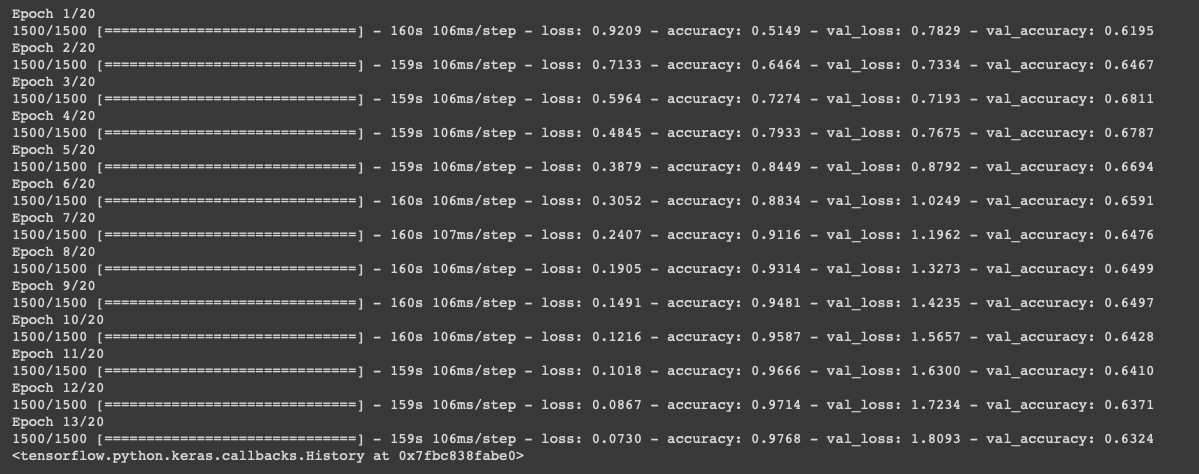

In [ ]:
#model.save('multiclass.h5')

mm1 = load_model('../input/weights/multiclass.h5')

In [ ]:
pred = mm1.predict_classes(xTest)

import numpy as np
rounded_labels=np.argmax(yTest, axis=1)
rounded_labels

**Confusion_Matrix**

In [ ]:
confusion_matrix(rounded_labels,pred)

Acuracy Score for Multiclass Classification

In [ ]:
accuracy_score(rounded_labels,pred)

# Multilabel Classification 

In [ ]:
allTags = data['Tags'].apply(lambda x:x.lower())
allTags = list(allTags.values)
allTags = ''.join(allTags)
count = Counter(allTags.split())
len(count) # unique Tags

In [ ]:
count = pd.DataFrame(list(dict(count).items()),columns = ['Technology','Count'])
count.astype({'Count':'int64'})

count.sort_values('Count',axis =0,ascending = False,inplace = True)

Checking Technologies- Tags and their frequency

In [ ]:
fig = px.scatter(count, x = 'Technology',y='Count',size='Count',color='Count')

fig.update_layout(title='All Technologie\'s-Tags and their Frequency',xaxis=dict(title='Technology'),yaxis=dict(title='No. of Questions'))

fig.show()

Remove the Tech who have less than 1000 count

In [ ]:
count = count[count['Count']>=1000]

In [ ]:
fig = px.scatter(count, x = 'Technology',y='Count',size='Count',color='Count')

fig.update_layout(title='Technologie\'s have Frequency greater than 1000',xaxis=dict(title='Technology'),yaxis=dict(title='No. of Questions'))

fig.show()

> We have 23 multilabel which cover most of the questions

> We will save these 23 Multilabel Tags in Variable tech List

In [ ]:
tech = list(count['Technology'].values)
len(tech) # we have 23 multilabe which cover most of the questions

Checking Tags if they are present in tech list then we will pass list in Tags Column otherwise will pass None

In [ ]:
def FinalTags(tags):
  t = list()
  for tag in tags.split():
    if (tag.lower() in tech):
      t.append(tag)
  if(t==[]):
    return None
  else:
    return t
data['Tags'] = data['Tags'].apply(FinalTags)
data.isna().sum()

After Checking Tags we now have 13k value as None values 

We will simply drop this for further Classification

In [ ]:
data.dropna(inplace= True,axis= 0)
data.isna().sum()

To Prepare for Multilabel Classification We will use MultiLabelBinarizer for the Target Labels and same step for the Question Text

In [ ]:
multi = MultiLabelBinarizer()
y = multi.fit_transform(data['Tags'])

In [ ]:
token = Tokenizer(vocab,lower=True,oov_token=oov_tok)
token.fit_on_texts(data['question'])
seq = token.texts_to_sequences(data['question'])
padded = pad_sequences(seq,padding = 'post',truncating='post',maxlen=text_length)

padded.shape

In [ ]:
xTrain,xTest,yTrain,yTest = train_test_split(padded,y,test_size = 0.2,random_state = 2)

In [ ]:
model = Sequential()

model.add(Embedding(vocab,embedding_dim,input_length=xTrain.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(250))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(yTrain.shape[1]))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
call = EarlyStopping(monitor='val_loss',verbose=0,patience=6)

#model.fit(xTrain,yTrain,epochs=20,validation_data=(xTest,yTest),callbacks=[call],verbose = 1)

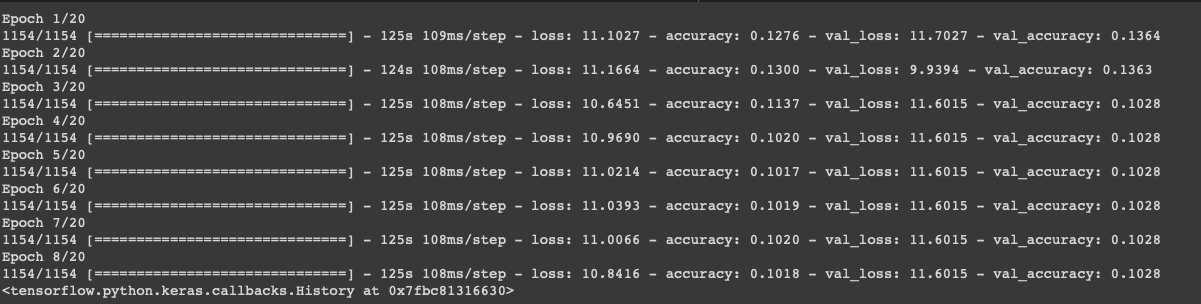

In [ ]:
#model.save('Labels.h5')
mm2 = load_model('../input/weights/Labels.h5')

In [ ]:
rounded_labels=np.argmax(yTest, axis=1)
pred = mm1.predict_classes(xTest)

In [ ]:
confusion_matrix(rounded_labels,pred)

For models weights(h5)and Preprocessed Dataset 

I, First save into output file and later download and upload into input file

because after refreshing kaggle kernel get return to it's previous state so it's remove the output file

If you Guys have any Suggestion/s or any tips to improve classification Model or this kaggle notebook please Comment it will help me to improvise alot

Thank You